---
# <div align="center"><font color='blue'>  </font></div>
# <div align="center"><font color='blue'> COSC 2779/2972 | Deep Learning  </font></div>
## <div align="center"> <font color='blue'> Week 8 Lecture Example: **Sequential Data - Applications**</font></div>
---

In this example we will explore word embeddings and their role in NLP.


# Setting up the Notebook

Let's first load the packages we need.

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt

import io
import os
import re
import string

We can also write our own function to plot the models training history ones training has completed.

In [2]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

# Train a word embedding

## Loading the dataset


We will use the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) through the example. We will train a sentiment classifier model on this dataset and in the process learn embeddings from scratch. To read more about loading a dataset from scratch, see the [Loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text).  

Download the dataset using Keras file utility and take a look at the directories.

In [3]:
import os
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

84140032/84125825 [==============================] - 5s 0us/step


['imdb.vocab', 'README', 'train', 'imdbEr.txt', 'test']

Take a look at the train/ directory. It has pos and neg folders with movie reviews labelled as positive and negative respectively. You will use reviews from pos and neg folders to train a binary classification model.

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'neg',
 'urls_unsup.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'urls_neg.txt',
 'unsup']

The `train` directory also has additional folders which should be removed before creating training dataset.

In [5]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, create a `tf.data.Dataset` using `tf.keras.utils.text_dataset_from_directory`. You can read more about using this utility in this [text classification tutorial](https://www.tensorflow.org/tutorials/keras/text_classification). 

Use the `train` directory to create both train and validation datasets with a split of 20% for validation.

In [6]:
batch_size = 1024
seed = 123
train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Take a look at a few movie reviews and their labels `(1: positive, 0: negative)` from the train dataset.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without


These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Using the Embedding layer

Keras makes it easy to use word embeddings. Take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [9]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [10]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.01047689,  0.00579989,  0.04215361,  0.03453847,  0.03471136],
       [-0.04747926, -0.01844645,  0.03592176, -0.01339736, -0.00380454],
       [-0.01752063, -0.03602203,  0.03858831,  0.0089861 ,  0.03315592]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a (2, 3) input batch and the output is (2, 3, N)

In [11]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's the simplest. The [Text Classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn) tutorial is a good next step.

### Text preprocessing

Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews. You can learn more about using this layer in the [Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial.

In [12]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

## Create a classification model

Use the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) to define the sentiment classification model. In this case it is a "Continuous bag of words" style model.
* The [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer transforms strings into vocabulary indices. You have already initialized `vectorize_layer` as a TextVectorization layer and built its vocabulary by calling `adapt` on `text_ds`. Now vectorize_layer can be used as the first layer of your end-to-end classification model, feeding transformed strings into the Embedding layer.
* The [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* The [`GlobalAveragePooling1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* The fixed-length output vector is piped through a fully-connected ([`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer with 16 hidden units.

* The last layer is densely connected with a single output node. 

Caution: This model doesn't use masking, so the zero-padding is used as part of the input and hence the padding length may affect the output.  To fix this, see the [masking and padding guide](https://www.tensorflow.org/guide/keras/masking_and_padding).

In [13]:
embedding_dim=16

model = tf.keras.models.Sequential([
  vectorize_layer,
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding"),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1)
])

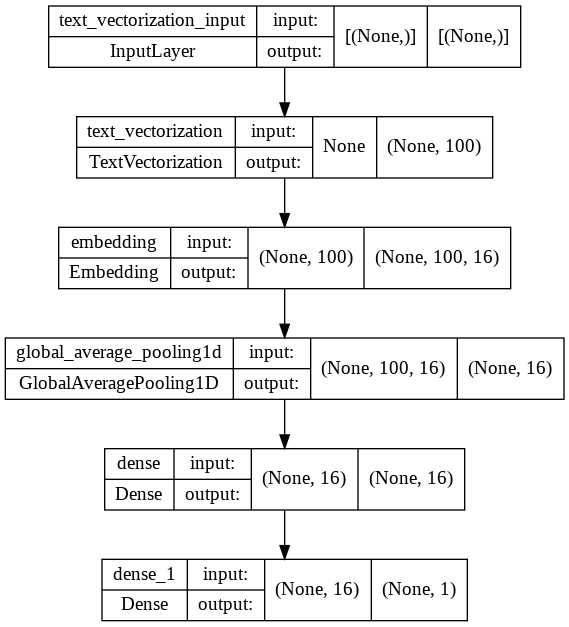

In [14]:
tf.keras.utils.plot_model(model,show_shapes=True)

## Compile and train the model

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Compile and train the model

In [16]:
m_histories = {}
m_histories['Train_word_embedding'] = model.fit(train_ds,validation_data=val_ds,epochs=15,)

Epoch 1/15
20/20 [==============================] - 5s 226ms/step - loss: 0.6922 - accuracy: 0.5028 - val_loss: 0.6903 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 2s 81ms/step - loss: 0.6878 - accuracy: 0.5028 - val_loss: 0.6846 - val_accuracy: 0.4886
Epoch 3/15
20/20 [==============================] - 2s 81ms/step - loss: 0.6801 - accuracy: 0.5028 - val_loss: 0.6748 - val_accuracy: 0.4886
Epoch 4/15
20/20 [==============================] - 2s 81ms/step - loss: 0.6676 - accuracy: 0.5028 - val_loss: 0.6599 - val_accuracy: 0.4886
Epoch 5/15
20/20 [==============================] - 2s 81ms/step - loss: 0.6488 - accuracy: 0.5038 - val_loss: 0.6391 - val_accuracy: 0.4942
Epoch 6/15
20/20 [==============================] - 2s 104ms/step - loss: 0.6237 - accuracy: 0.5454 - val_loss: 0.6133 - val_accuracy: 0.5604
Epoch 7/15
20/20 [==============================] - 3s 166ms/step - loss: 0.5932 - accuracy: 0.6230 - val_loss: 0.5841 - val_accuracy: 0.6324
Epoch 8/15

## Retrieve the trained word embeddings and save them to disk

Next, retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape `(vocab_size, embedding_dimension)`.

Obtain the weights from the model using `get_layer()` and `get_weights()`. The `get_vocabulary()` function provides the vocabulary to build a metadata file with one token per line. 

In [17]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

Write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), you will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [18]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [19]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To visualize the embeddings, upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files you created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Write the embedding in to file in glove format so that it can be loaded later

In [20]:
out_emb = io.open('embedding.txt', 'w')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_emb.write(word + ' ' + ' '.join([str(x) for x in vec]) + "\n")
out_emb.close()